# Autoencoder


"Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). 



In [0]:
import pandas as pd
import numpy as np
import os

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch.autograd import Variable

from tqdm import tqdm

from collections import OrderedDict

from torchvision import datasets, models, transforms

from livelossplot import PlotLosses

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
DEVICE = torch.device('cuda')
H, W = 128, 128 

In [0]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!tar -zxvf lfw-deepfunneled.tgz
!mv lfw-deepfunneled data

Обработчик картинок


In [0]:
class ClassImageDataSet(Dataset):
    def __init__(self, files):
        super().__init__()
        self.files = sorted(files)
        self.len_ = len(self.files)
        
    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __len__(self):
        return self.len_
    
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.CenterCrop([150,150]),
            transforms.Resize([H, W]),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1))
        ])

        x = self.load_image(self.files[index])
        x = transform(x)

        return x

In [0]:
def image(data = 'data'):
    image = []
    for dirpath, dirnames, filenames in os.walk(data):
        for filename in filenames:
            image.append({'file_path':os.path.join(dirpath,filename)})
    return  pd.DataFrame(image)['file_path'].values  

In [0]:
train_files, test_files = train_test_split(image(), test_size = 0.2)

In [0]:
train_df = ClassImageDataSet(train_files)
test_df = ClassImageDataSet(test_files)

In [0]:
batch_size = 32 
train_loader= DataLoader(train_df, batch_size = batch_size, shuffle = True)
val_loader= DataLoader(test_df, batch_size = batch_size, shuffle = True)

In [0]:
# Функция для обучения одной тренировочной эпохи.
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0
  
    for inputs in train_loader:
        inputs = inputs.to(DEVICE)
    
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    train_loss = running_loss/ processed_data

    return train_loss

In [0]:
# Функция валидационной эпохи.
def val_epoch(model, val_loader, criterian):
    model.eval()
    running_loss = 0.0
    processed_data = 0
    
    for inputs in val_loader:
        inputs = inputs.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterian(outputs, inputs)
            
            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)
    
    val_loss = running_loss/ processed_data
    return val_loss

In [0]:
#Функция обучения модели с выводом графика loss-a и сохранения лучшей модели
liveloss = PlotLosses()
def train(train_loader, val_loader, model, criterion, optimizer, scheduler,  epochs):
    history = []
    
    best_vall = 1.0
    
    model = model.to(DEVICE)

    for epoch in range(epochs):
        
        train_loss = fit_epoch(model, train_loader, criterion, optimizer)
        print('loss', train_loss)

        
        valid_loss = val_epoch(model, val_loader, criterion)
        print('val_loss', valid_loss)
        
        val_pred(val_loader, model)
        history.append((train_loss, valid_loss))
        
        scheduler.step(valid_loss)
        
        liveloss.update({
            'loss': train_loss,
            'val_loss': valid_loss
        })
        
        liveloss.draw() 
        
        if best_vall > valid_loss:
            best_vall = valid_loss
            model.cpu()
            torch.save(model.state_dict(), 'callback/fin_bce_izi.pth')
            model.to(DEVICE)
    return history, best_vall

In [0]:
#Функция получения результатов autoencoder-а
def val_pred(val_loader, model):
    with torch.no_grad():
        
        for inputs in val_loader:
            inputs = inputs.to(DEVICE)
            
            model.eval()
            outputs = model(inputs)
            drow_image([inputs.cpu(),outputs.cpu()], H, W, 1, 2)
            break
    pass

In [0]:
#Функция вывода картинок
def drow_image(x, h, w, n_row=3, n_col=6):
    p = 1
    ToPIL = transforms.ToPILImage()
    plt.figure(figsize=(3 * n_col, 3.5 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    if type(x) == list:
        for i in range(n_row):
            for j in range (n_col):
                plt.subplot(n_row, n_col, p)
                plt.imshow(ToPIL(x[j][i].reshape((3, h, w))))
                plt.xticks(())
                plt.yticks(())
                p += 1
    else:
        for i in range(n_row * n_col):
            plt.subplot(n_row, n_col, i + 1)
            plt.imshow(ToPIL(x[i].reshape((3, h, w))))
            plt.xticks(())
            plt.yticks(())
    pass

In [0]:
#Вспомогательные классы для преобразования данных в модели
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

## Модель autoencoder


In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(OrderedDict([
                                    ('conv1_1', nn.Conv2d(3, 32, 3,stride = 1, padding = 1)), #b, 32, 128, 128
                                    ('bn1_1', nn.BatchNorm2d(32)),
                                    ('Relu1_1', nn.ReLU()),
                                    ('conv1_2', nn.Conv2d(32, 64 , 3, stride =2, padding = 1)), # b, 64, 64, 64
                                    ('bn1_2', nn.BatchNorm2d(64)),
                                    ('Relu1_2', nn.ReLU()),
                                    ('conv1_3', nn.Conv2d(64, 128, 3, stride =1, padding = 1)), # b, 128, 64, 64
                                    ('bn1_3', nn.BatchNorm2d(128)),
                                    ('Relu1_3', nn.ReLU()),
                                    ('conv1_4', nn.Conv2d(128, 256, 3, stride =2, padding = 1)), # b, 256, 32, 32
                                    ('bn1_4', nn.BatchNorm2d(256)),
                                    ('Relu1_4', nn.ReLU()),
                                    ('conv1_5', nn.Conv2d(256, 512, 3, stride =1, padding = 1)), # b, 128, 64, 64
                                    ('bn1_5', nn.BatchNorm2d(512)),
                                    ('Relu1_5', nn.ReLU()),
                                    ('conv1_6', nn.Conv2d(512, 512, 3, stride =2, padding = 1)), # b, 512, 16, 16
                                    ('bn1_6', nn.BatchNorm2d(512)),
                                    ('Relu1_6', nn.ReLU()),
                                    ('conv1_7', nn.Conv2d(512, 256, 3, stride =1, padding = 1)), # b, 256, 16, 16
                                    ('bn1_7', nn.BatchNorm2d(256)),
                                    ('Relu1_7', nn.ReLU()),
                                    ('conv1_8', nn.Conv2d(256, 128, 3, stride =1, padding = 1)), # b, 128, 16, 16
                                    ('bn1_8', nn.BatchNorm2d(128)),
                                    ('Relu1_8', nn.ReLU()),
                                    ('conv1_9', nn.Conv2d(128, 64, 3, stride =1, padding = 1)), # b, 64, 16, 16
                                    ('bn1_9', nn.BatchNorm2d(64)),
                                    ('Relu1_9', nn.ReLU()),
                                    ('Flatten', Flatten()),
                                    ('FC_E1', nn.Linear(64 * 16 * 16, 2048)),
                                    ('BN_E1', nn.BatchNorm1d(2048)),
                                    ('Relu_1_10', nn.ReLU()),
                                    ('FC_E2', nn.Linear(2048, 1024)),
                                    ('BN_E2', nn.BatchNorm1d(1024)),
                                    ('Sigmoid_1', nn.Sigmoid())
                                    ]))
        
        
        self.decoder = nn.Sequential(OrderedDict([
                                    ('FC_D_1', nn.Linear(1024, 2048)),
                                    ('BN_D_1', nn.BatchNorm1d(2048)),
                                    ('Relu_D1', nn.ReLU()),
                                    ('FC_D2', nn.Linear(2048, 64 *16 *16)),
                                    ('BN_D2', nn.BatchNorm1d(64 * 16 * 16)),
                                    ('Relu_D2', nn.ReLU()),
                                    ('Reshape', Reshape(-1,64,16,16)),
                                    ('conv2_1', nn.ConvTranspose2d(64, 128, 3, stride = 1, padding = 1)),  # b, 128, 16, 16
                                    ('bn2_1', nn.BatchNorm2d(128)),
                                    ('Relu2_1', nn.ReLU()),
                                    ('conv2_2', nn.ConvTranspose2d(128, 256, 3, stride = 1, padding = 1)),  # b, 256, 16, 16
                                    ('bn2_2', nn.BatchNorm2d(256)),
                                    ('Relu2_2', nn.ReLU()),
                                    ('conv2_3', nn.ConvTranspose2d(256, 512, 3, stride = 1, padding = 1)),  # b, 512, 16, 16
                                    ('bn2_3', nn.BatchNorm2d(512)),
                                    ('Relu2_3', nn.ReLU()),
                                    ('conv2_4', nn.ConvTranspose2d(512, 512, 3, stride = 2, padding = 1,output_padding=1)), # b, 512, 32, 32
                                    ('bn2_4', nn.BatchNorm2d(512)), 
                                    ('Relu2_4', nn.ReLU()),
                                    ('conv2_5', nn.ConvTranspose2d(512, 256, 3, stride = 1, padding = 1)), # b, 256, 32, 32
                                    ('bn2_5', nn.BatchNorm2d(256)),
                                    ('Relu2_5', nn.ReLU()),
                                    ('conv2_6', nn.ConvTranspose2d(256, 128, 3, stride = 2, padding = 1, output_padding=1)), # b, 128, 64, 64
                                    ('bn2_6', nn.BatchNorm2d(128)),
                                    ('Relu2_6', nn.ReLU()),
                                    ('conv2_7', nn.ConvTranspose2d(128, 64, 3, stride = 1,  padding = 1 )), # b, 64, 64, 64
                                    ('bn2_7', nn.BatchNorm2d(64)),
                                    ('relu2_7', nn.ReLU()),
                                    ('conv2_8', nn.ConvTranspose2d(64, 32, 3, stride = 2, padding = 1, output_padding=1)), # b, 32, 128, 128
                                    ('bn2_8', nn.BatchNorm2d(32)),
                                    ('Relu2_8', nn.ReLU()),
                                    ('conv2_9', nn.ConvTranspose2d(32, 3, 3, stride = 1,  padding = 1 )), # b, 3, 128, 128
                                    ('Sigmoid_2', nn.Sigmoid())
                                    ]))
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return  x

In [0]:
autoencoder = AutoEncoder()

In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.00001)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',factor=0.001, patience=5, verbose = True)

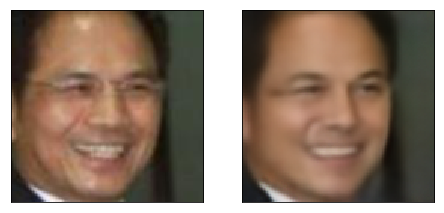

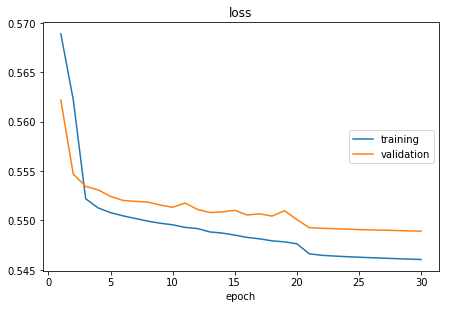

loss:
training   (min:    0.546, max:    0.569, cur:    0.546)
validation (min:    0.549, max:    0.562, cur:    0.549)


In [0]:
history, best_vall = train(train_loader, val_loader, autoencoder, criterion, optimizer,sheduler, 10)

In [0]:
autoencoder.load_state_dict(torch.load('callback/fin_bce_izi.pth'))

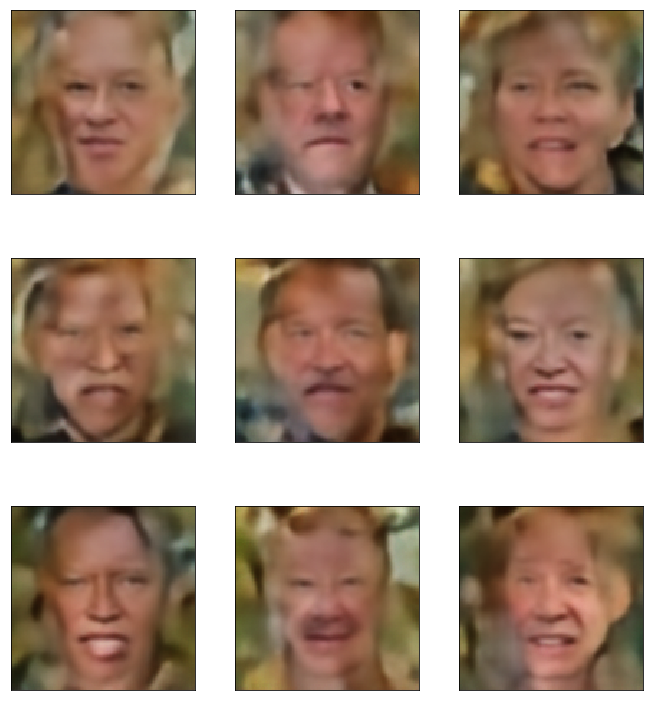

In [0]:
z = np.random.rand(9, 1024) 

output = autoencoder.decoder(torch.FloatTensor(z).to(DEVICE))
drow_image(output.cpu(), H, W, n_row=3, n_col=3)

### Добавление улыбок


In [0]:
smile = ClassImageDataSet(image('smile'))
sad = ClassImageDataSet(image('trist'))
example = ClassImageDataSet(image('example')) 

In [0]:
bs_smile = 8
smile_loader = DataLoader(smile, batch_size = bs_smile, shuffle = True)
sad_loader = DataLoader(trist, batch_size = bs_smile, shuffle = True)
example_loader = DataLoader(example, batch_size = 2, shuffle = False)

In [0]:
def gen_smile(smile_loader,trist_loader, picture_loader, model):
    model = model.to(DEVICE)
    
    laten_vc_smile = 0.0
    processed_data_smile = 0
    
    laten_vc_trist = 0.0
    processed_data_trist = 0
    
    with torch.no_grad():
        
        for inputs in smile_loader:
            inputs = inputs.to(DEVICE)
            outputs = model.encoder(inputs)
            outputs = outputs.mean(0)
            
            laten_vc_smile += outputs
            processed_data_smile += 1
       
        laten_vector_smile = laten_vc_smile / processed_data_smile

        for inputs in trist_loader:
            inputs = inputs.to(DEVICE)

            outputs = model.encoder(inputs)
            outputs_mean = outputs.mean(0)
            
            laten_vc_trist += outputs_mean
            processed_data_trist += 1

        laten_vector_trist = laten_vc_trist / processed_data_trist

        vector = laten_vector_smile - laten_vector_trist

        for inputs in picture_loader:
            inputs = inputs.to(DEVICE)
            vector = vector.to(DEVICE)
            
            outputs = model.encoder(inputs)
            image_with_smile = outputs + vector
            gen_image = model.decoder(image_with_smile)
            image_autoencoder = model(inputs)
            
    return inputs.cpu(), image_autoencoder.cpu(), gen_image.cpu()

In [0]:
origin, predict, gen_image = gen_smile(smile_loader,sad_loader, example_loader, autoencoder)

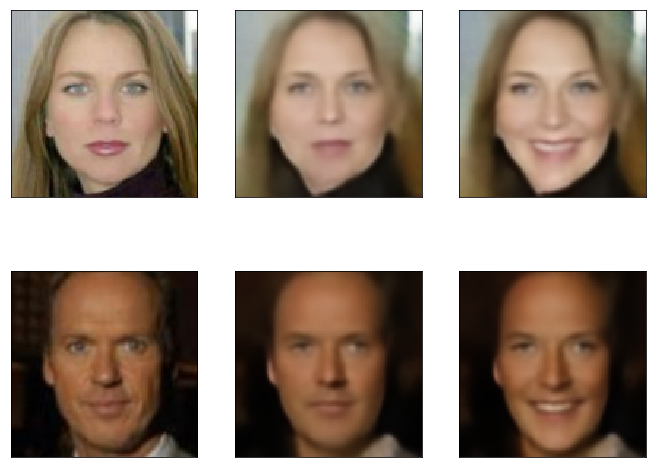

In [0]:
drow_image([origin, predict, gen_image], H, W, n_row=2, n_col=3)

**********************************************